In [1]:
# Author  : BALACHANDAR S
# Version : V1.0
# Project Assigned Date   : 01-Feb-23
# Project Deadline Date   : 10-Feb-23
# Estimated Complete Date : 05-Feb-23
# Project Completed Date  : 05-Feb-23

#New York Job Posting - This dataset contains current job postings available on the City of New York’s official jobs site.
#Working on problem statement or use cases and providing the result.

# Application design considers below aspect
#   1. Code Reusabilty
#   2. Code Formatting
#   3. Performance Factors
#   4. Utilization of Feature Engineering Techniques
#   5. Provision of TestCases for methods that are required to be tested.
#   6. Comments & Explanations

# TestCases Available in bottom of the page
# Chart & Bar Plot are used to enhance the representation of data

In [2]:
# All Imports are handled in this section
import sys;
import findspark
import time
findspark.init()
from pyspark.sql import SparkSession,DataFrameNaFunctions
from pyspark.sql import functions as F
from pyspark.sql.functions import year,date_format,to_date,udf,col,avg,count,desc,lit
from pyspark.sql.types import DecimalType,FloatType,DoubleType,IntegerType,DateType,StructType,StructField,StringType
import pandas as pd
import numpy  as np
import unittest
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from decimal import Decimal  
startTime = time.time()

sys.path.insert(0, '..')

# Spark Object is initiated
spark = SparkSession.builder. \
    appName("NewYork_Job_Details"). \
    getOrCreate()

spark.conf.set("mapreduce.fileoutputcommitter.marksuccessfuljobs", "false")
spark.conf.set("fs.file.impl.disable.cache", "true")

format = "yyyy-MM-dd'T'HH:mm:ss.SSS"
schema_info = StructType([
StructField('Job ID'                     , StringType()  , True),
StructField('Agency'                     , StringType()  , True),
StructField('Posting Type'               , StringType()  , True),
StructField('# Of Positions'             , IntegerType() , True),
StructField('Business Title'             , StringType()  , True),
StructField('Civil Service Title'        , StringType()  , True),
StructField('Title Code No'              , StringType()  , True),
StructField('Level'                      , IntegerType() , True),
StructField('Job Category'               , StringType()  , True),
StructField('Full Part Time Indicator'   , StringType()  , True),
StructField('Salary Range From'          , DoubleType()  , True),
StructField('Salary Range To'            , DoubleType()  , True),
StructField('Salary Frequency'           , StringType()  , True),
StructField('Work Location'              , StringType()  , True),
StructField('Division Work Unit'         , StringType()  , True),
StructField('Job Description'            , StringType()  , True),
StructField('Minimum Qual Requirements'  , StringType()  , True),
StructField('Preferred Skills'           , StringType()  , True),
StructField('Additional Information'     , StringType()  , True),
StructField('To Apply'                   , StringType()  , True),
StructField('Hours Shift'                , StringType()  , True),
StructField('Work Location 1'            , StringType()  , True),
StructField('Recruitment Contact'        , StringType()  , True),
StructField('Residency Requirement'      , StringType()  , True),
StructField('Posting Date'               , DateType()    , True),
StructField('Posting Until'              , DateType()    , True),
StructField('Posting Updated'            , DateType()    , True),
StructField('Process Date'               , DateType()    , True)])

# Convert String to Date Method
def convertStrToDate(get_date) : 
    return F.unix_timestamp((get_date),format).cast('timestamp')

# Reading CSV File from /dataset/ directory
# Schema is inter-referrenced 
# Quotes and Escape Sequence are handled while loading itself
# Loading data with HEADER 
# ------------------------------------------------------------

df = spark.read.csv("/dataset/nyc-jobs.csv" \
    , schema=schema_info   \
    , quote="\""           \
    , escape="\""          \
    , header=True          \
    , encoding= "UTF-8")

# Preprocessing data based on Posting Date to YEAR level 
# Removing duplicate records
df=df.dropDuplicates().withColumn("Posting Year", date_format(col("Posting Date").cast("date"),'YYYY'))

#Applying Feature Engineering Techinques for better and faster processing
# StringIndexer -  Renaming the values internally for faster and better performance. 
# Data load of the system will be reduced as we are using distinct indexing logic.
strInd=['Job Category','Civil Service Title','Agency','Business Title']
for item in strInd:
    job_category_index = StringIndexer(inputCol=item, outputCol=item+' Indexer').setHandleInvalid("skip") 
    df_transformed=job_category_index.fit(df).transform(df)

# VectorAssembler - It can be used for the column that requires combined processing perspective.
#  -Only Integer inputs are allowed to be stacked.
assembler = VectorAssembler(inputCols=["Salary Range From","Salary Range To"] ,outputCol="Salary Ranges")
df_transformed=assembler.transform(df)

# Printing Core Dataframe Schema Info
df_transformed.printSchema()


root
 |-- Job ID: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: integer (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: integer (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full Part Time Indicator: string (nullable = true)
 |-- Salary Range From: double (nullable = true)
 |-- Salary Range To: double (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply: string (nullable = true)
 |-- Hours Shift: string (nullable = true)
 |-- Work Location 1

In [3]:
# Converting DF ((pyspark) -> Pandas (dataframe) for statistical analysis purpose
df_pandas=df.select("*").toPandas()
df_pandas_tmp=df_pandas
print("Rows1:{} , Column:{} ".format(df_pandas.shape[0], df_pandas.shape[1]))

Rows1:2457 , Column:29 


In [4]:
# Displays all attributes
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2457 entries, 0 to 2456
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Job ID                     2456 non-null   object 
 1   Agency                     2456 non-null   object 
 2   Posting Type               2456 non-null   object 
 3   # Of Positions             2456 non-null   float64
 4   Business Title             2456 non-null   object 
 5   Civil Service Title        2456 non-null   object 
 6   Title Code No              2456 non-null   object 
 7   Level                      2456 non-null   float64
 8   Job Category               2455 non-null   object 
 9   Full Part Time Indicator   2296 non-null   object 
 10  Salary Range From          2456 non-null   float64
 11  Salary Range To            2456 non-null   float64
 12  Salary Frequency           2456 non-null   object 
 13  Work Location              2456 non-null   objec

In [5]:
# Displaying null record count in percentage. 
# if Any column with 100% from below query, 
#   It can be removed as it will be of no use.
#   Point to Remember : The column which is supposed to removed should not make impact.
tot_rec_count=len(df_pandas_tmp)
for get_curr_column in df_pandas_tmp.columns:
    if df_pandas_tmp[get_curr_column].isnull().any():
        rec_count=df_pandas_tmp[get_curr_column].isnull().sum()
        percentage="{:.2f}".format((rec_count/tot_rec_count ) *100)
        print(' {0} ({1}%) Records contain Null Records in "{2}" has null values'.format( rec_count, percentage , get_curr_column))


 1 (0.04%) Records contain Null Records in "Job ID" has null values
 1 (0.04%) Records contain Null Records in "Agency" has null values
 1 (0.04%) Records contain Null Records in "Posting Type" has null values
 1 (0.04%) Records contain Null Records in "# Of Positions" has null values
 1 (0.04%) Records contain Null Records in "Business Title" has null values
 1 (0.04%) Records contain Null Records in "Civil Service Title" has null values
 1 (0.04%) Records contain Null Records in "Title Code No" has null values
 1 (0.04%) Records contain Null Records in "Level" has null values
 2 (0.08%) Records contain Null Records in "Job Category" has null values
 161 (6.55%) Records contain Null Records in "Full Part Time Indicator" has null values
 1 (0.04%) Records contain Null Records in "Salary Range From" has null values
 1 (0.04%) Records contain Null Records in "Salary Range To" has null values
 1 (0.04%) Records contain Null Records in "Salary Frequency" has null values
 1 (0.04%) Records 

In [6]:
# Creating Dictionary Object
empty_dict = {
    "Job Category"                  : "UnIdentified",
    "Full Part Time Indicator"      : "NA",
    "Minimum Qual Requirements"     : "TBD",
    "Preferred Skills"              : "Others" ,
    "Additional Information"        : "NA" ,
    "Residency Requirement"         : "No details on Recidency " ,
    "To Apply"                      : "No Instructions Provided" ,
    "Work Location 1"               : "Location Not Provided" ,
    "Hours Shift"                   : "NA" 
}

# Assign DICT in existing dF. This helps the system faster.
#  Addition of Point : We can also apply StringIndexer Feature Engineering Techinique after making this change.
def handleEmptyFieldColumns(df_pandas_tmp,df_pandas) :
    for key,value in empty_dict.items():
        df_pandas[key]=df_pandas_tmp[key].replace(np.nan,value)

#df_pandas.dropna(how='all', axis=1, inplace=True)

# Calling EmptyField Validation 
handleEmptyFieldColumns(df_pandas,df_pandas)
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2457 entries, 0 to 2456
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Job ID                     2456 non-null   object 
 1   Agency                     2456 non-null   object 
 2   Posting Type               2456 non-null   object 
 3   # Of Positions             2456 non-null   float64
 4   Business Title             2456 non-null   object 
 5   Civil Service Title        2456 non-null   object 
 6   Title Code No              2456 non-null   object 
 7   Level                      2456 non-null   float64
 8   Job Category               2457 non-null   object 
 9   Full Part Time Indicator   2457 non-null   object 
 10  Salary Range From          2456 non-null   float64
 11  Salary Range To            2456 non-null   float64
 12  Salary Frequency           2456 non-null   object 
 13  Work Location              2456 non-null   objec

Text(0.5, 0, 'Year')

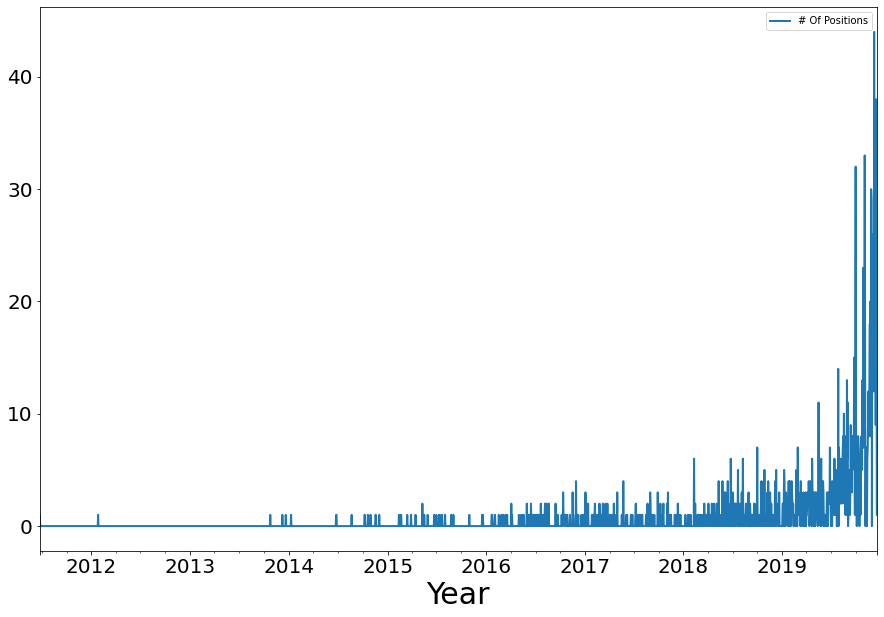

In [7]:
# All imports
import matplotlib.pyplot as plt
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #Data Ploting
import seaborn as sns #Data Ploting
import operator
import math 
import string
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Below Plot shows the comparision between number of positions with respective to Posting Date (YYYY Format)
# Learning / Assumption from below chart:
#   1. Number of Positions are consistently raised year on year.
#   2. Every 6 months, there is a spike in bar. This indicates- for every 6 months, mild fluctuation in attrition  
#      ration.
#   3. After 2019-06, there is huge upward rise. There should be big impact from job search.

df_for_analysis = pd.read_csv("/dataset/nyc-jobs.csv",index_col='Posting Date', parse_dates=['Posting Date']) 
dir(df_for_analysis)
df_for_analysis=df_for_analysis.drop("Posting Type", axis=1).drop_duplicates()
df_for_analysis[["# Of Positions"]].resample('B').count().plot(figsize=(15,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=30) 


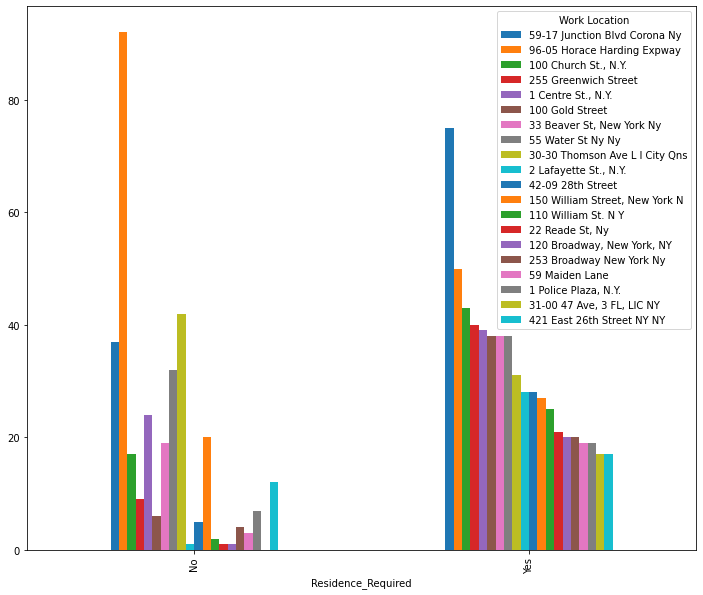

In [8]:

# Below Plot shows the location which demands to the employee to be available in the location as resident. 
# Refer below catories available in diagram.
#   YES - If employee requires to be working in their organization, they should mandatorily reside in location
#       - Refer 'Residency Requirement' Column and find if it does not contain word as 'not required'
#   NO  - If employee requires to be working in their organization, no restriction in residence.
#       - Refer 'Residency Requirement' Column and find if it contains word as 'not required' 
# Learning / Assumption from below chart:
#   1. Majority of Organization requires employee to reside near their work location.
#   2. By below chart, it is observed that '59-17 Junction Blvd Corona Ny' and '96-05 Horace Harding Expway' are almost same.
#      are have more counts. However, YES / NO count are not as same. 
#       -> This indicates, majority of organization requires candidate should reside in location '59-17 Junction Blvd Corona Ny'
#       -> In contrast, for every 1 company out of 3 do not have condition to candidate to stay in same location
#   3. Overall this data shows much clear information on which location major companies are much interested considering residence.


df_for_analysis['Residence_Required']=np.where(df_for_analysis['Residency Requirement'].str.contains("not required"),'No','Yes')
df_work_loc_residence = df_for_analysis[["Work Location","Residence_Required"]]

((pd.crosstab(index=df_work_loc_residence["Work Location"] , columns=df_work_loc_residence["Residence_Required"]))) \
    .sort_values(['Yes', 'No'] , ascending=[False, True]) \
              [:20].T.plot.bar(figsize=(12,10))


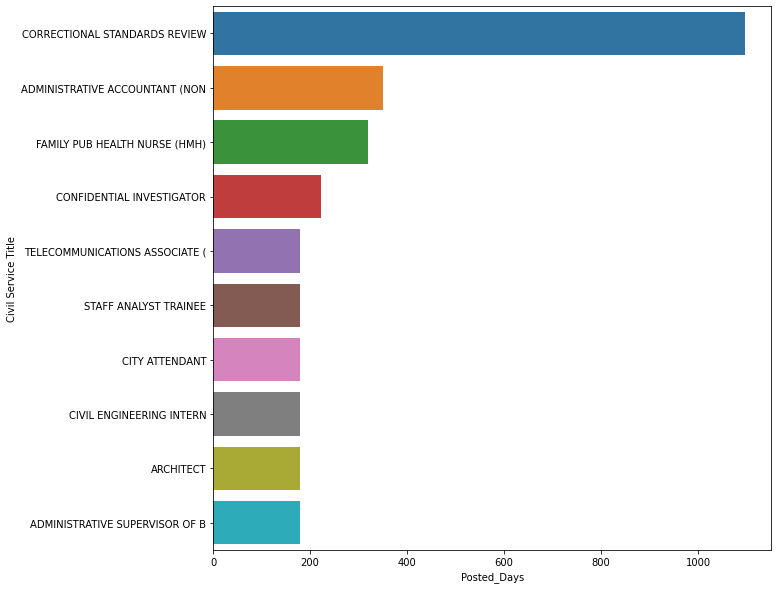

In [9]:

# Below Plot shows implies since how long the position was opened in day wise w.r.t to Civil Service Title
# Utilizing 'Posting Date', 'Posting Until' & 'Civil Service Title' column for the processing. Taking difference between 'Posting Until' and 'Posting Date'
# Below diagrams shows that 'CORRECTIONAL STANDARDS REVIEW' is on lead where the position was open for some long to file. 
#  -> This shows the organization should have more number of positions to fil it up. ows much clear information on which location major companies are much interested considering residence.

df_for_analysis_tmp = df_for_analysis.reset_index()
df_for_analysis_tmp['Posting Date'] =  df_for_analysis_tmp['Posting Date'].astype('datetime64[ns]')
df_for_analysis_tmp['Post Until']   =  df_for_analysis_tmp['Post Until'].astype('datetime64[ns]')
df_for_analysis_tmp["Posted_Days"]  = (df_for_analysis_tmp['Post Until'] - df_for_analysis_tmp['Posting Date']).dt.days
df_for_analysis_tmp = round(df_for_analysis_tmp.groupby(['Civil Service Title'], as_index=False)['Posted_Days'].mean(),2)
df_for_analysis_tmp = df_for_analysis_tmp.sort_values(["Posted_Days"],ascending=False)
plt.figure(figsize=(10,10))
sns.barplot(y=df_for_analysis_tmp["Civil Service Title"][:10],x=df_for_analysis_tmp.Posted_Days[:10])


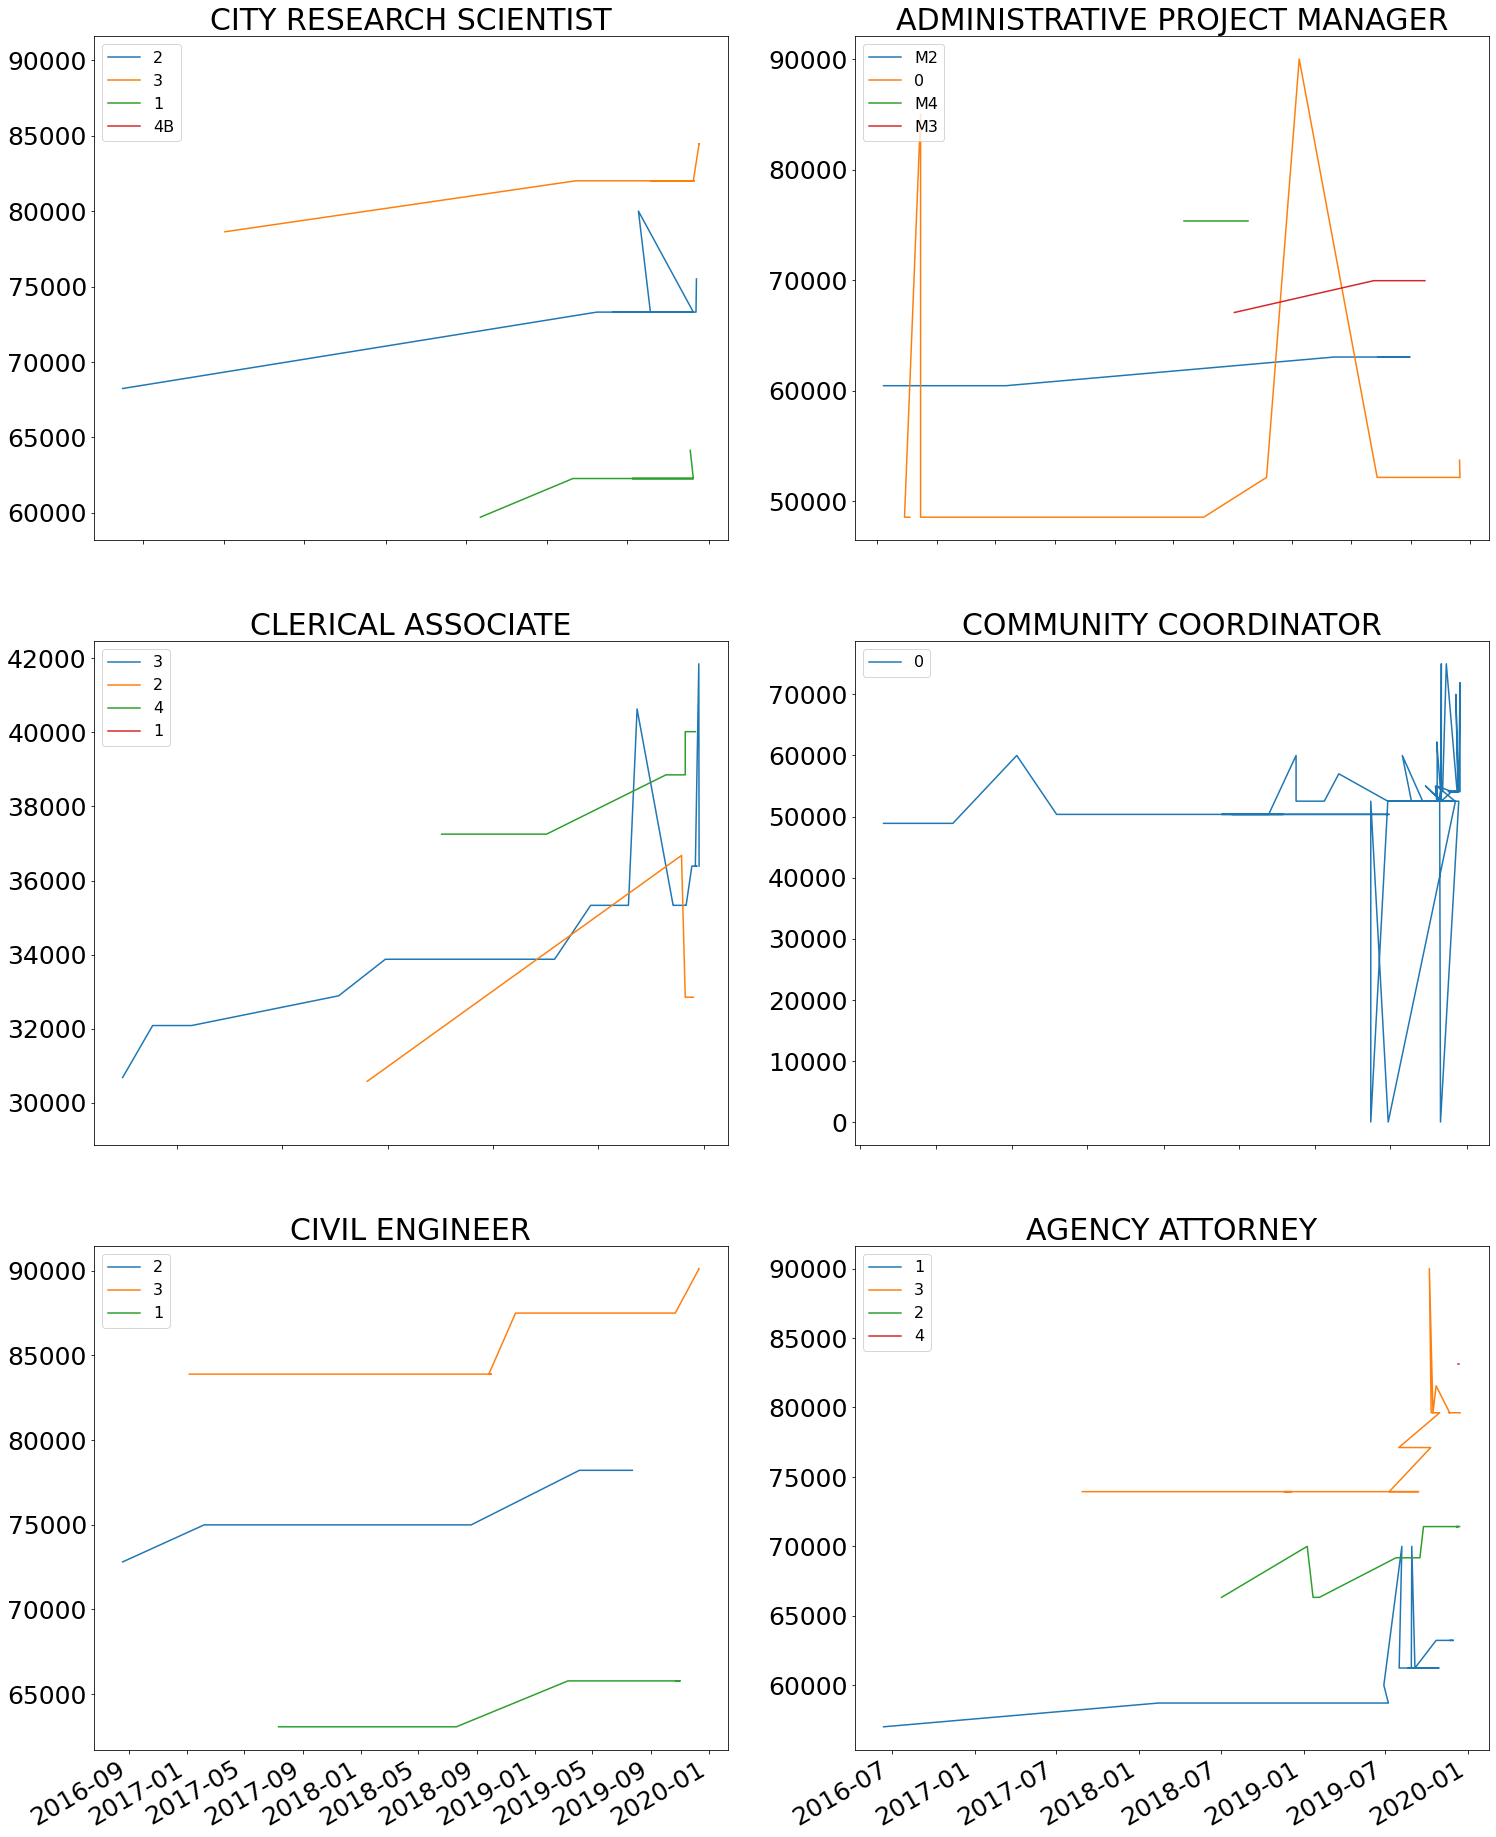

In [10]:

# Aim is to find Salary Range from which salary package that it fits in which difference level on year level.
# There are about six different variety/streams where post is available.
#   -> "CITY RESEARCH SCIENTIST","ADMINISTRATIVE PROJECT MANAGER","CLERICAL ASSOCIATE","COMMUNITY COORDINATOR","CIVIL ENGINEER","AGENCY ATTORNEY"
# For each Civil Service Title, we have category of levels (like 0,1,2,3,4A,4B,M1,M2 to M6)
#  Find how the salary has been increased/decreased over years. 
#  Analzing below plots, below are observations
#    1. City Research Scientist for LEVEL-3 has consitent salary start range. This category of work gives more outcome and that must be 
#       the reason for consistent hike.
#    2. Agency Attorney for LEVEL-3 neither have growth nor dip in start range. This implies the organization associated 
#       with Agency Attorney might not have seen bigger growth nor a dip.

title = ["CITY RESEARCH SCIENTIST","ADMINISTRATIVE PROJECT MANAGER","CLERICAL ASSOCIATE","COMMUNITY COORDINATOR","CIVIL ENGINEER","AGENCY ATTORNEY"]
df4 = df_for_analysis[(df_for_analysis['Full-Time/Part-Time indicator']=='F')
                       & df_for_analysis["Civil Service Title"].isin(title)
                      ][["Civil Service Title","Level","Salary Range From"]]
df4 = df4.reset_index()
plt.rcParams.update({'font.size': 25 })
#plt.rc('axes', titlesize=16)
plt.rc('legend', fontsize=16)

fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(25,35),linewidth=10)
k=0
for i in range(3):
    for j in range(2):
        levelList = list(df4[(df4['Civil Service Title']==title[k])]["Level"].unique())
        for level in levelList:
            tempDF = df4[(df4['Civil Service Title']==title[k]) & (df4.Level == level)]
            ax[i,j].plot(tempDF['Posting Date'], tempDF["Salary Range From"])
            ax[i,j].title.set_text(title[k])
            ax[i,j].legend(levelList,loc="upper left")
        k+=1
plt.gcf().autofmt_xdate()


In [11]:
# User Defined Function
# Dataset has salary frequency of ANNUAL, DAILY, HOURLY. For consolidation purpose, pre-processing frequency to ANNUAL basis.
# If it is hourly, it is assumed that candidate most likely to work 8 hours / working day over 261 Working days
# If it is daily,  it is assumed that candidate most likely to work for 261 Working days
# Considering above both factors, the function has been framed.

def calculateAnnualSalary(salary_range_from,salary_range_to,salary_frequency):
    annualSalary=0.0
    if salary_range_from is None:
        salary_range_from=0
    salary_range_from , salary_range_to = ((salary_range_from)) , ((salary_range_to)) 
    if  (salary_range_from > 0.0)  and  (salary_range_to > 0.0 ) :   
        if salary_frequency == 'Daily' :
            # Setting average working maximum including leapyear - 261
            salary_range_from = salary_range_from * 261
            salary_range_to   = salary_range_to   * 261       
        elif salary_frequency == 'Hourly'  :
            # Setting average working maximum including leapyear - 261
            salary_range_from = salary_range_from * 8 * 261
            salary_range_to   = salary_range_to * 8 * 261        
        annualSalary = (salary_range_from + salary_range_to) / 2         
    return annualSalary

# EOF calculateAnnualSalary
salaryCalculationUDF = udf(calculateAnnualSalary, FloatType()) 

level_dict = {
"M7":1, "M6":2, "M5":3, "M4":4, "M3":5, "M2":6, "M1":7,
"4B":8, "4A":9, "4":10, "3":11, "2":12, "1":13, "0":14,
} 

# Pre-Processing Level for finding out Qsn 4 - Correation between High Degree & Salary
def assignLevel(get_level):
    for key,value in level_dict.items() :
        if str(key) == str(get_level) : 
            return value

assignLevelUDF = udf(assignLevel, IntegerType()) 
def writeData(df,type_of_job):
    df.coalesce(1).write.mode("overwrite").option("header","true").csv("/dataset/"+type_of_job+"/")
    
print("Done with this block")


Done with this block


# List of KPIs to be resolved:

1. What's the number of jobs posting per category (Top 10)?
2. What's the salary distribution per job category?
3. Is there any correlation between the higher degree and the salary?
4. What's the job posting having the highest salary per agency?
5. What's the job postings average salary per agency for the last 2 years?
6. What are the highest paid skills in the US market?

In [12]:

# List of KPIs are covered 
# Windows function from Pyspark is utilized for calculating all 6 use cases.
# Key functions such as count, avg, max are used.
# ThreadPoolExecutor has been used for parallel processing purpose.
# 2 User Defined Functions are used.
#    1. salaryCalculationUDF - Used for calculating consolidated salary from start & max range of salary.
#    2. assignLevelUDF       - Assigning IntegerIndexer to fit into corr function.
# Final Output is stored in dataframe - df_with_salary_with

from pyspark.sql import Window
import pyspark.sql.functions as F
from concurrent.futures import ThreadPoolExecutor 
windows_agency = Window.partitionBy('Agency')
windows_job_category = Window.partitionBy('Job Category')
windows_civil_service_category = Window.partitionBy('Civil Service Title')
windows_agency_civil_service = Window.partitionBy('Agency','Civil Service Title')
df_with_salary_with=df.withColumn("Consolidated Annual Salary",   \
        salaryCalculationUDF( col("Salary Range From")     \
                             ,col("Salary Range To")       \
                             ,col("Salary Frequency")) )   \
    .withColumn("Level Mapping"           ,  assignLevelUDF(col("Level")))  \
    .select("Full Part Time Indicator","Level Mapping","Civil Service Title","Business Title","# Of Positions","Agency","Job Category","Consolidated Annual Salary","Posting Year","Level","Salary Range From","Salary Range To") \
    .withColumn("Job Category Count"      , F.count("Consolidated Annual Salary").over(windows_job_category)) \
    .withColumn("Salary Distribution"     , F.avg("Consolidated Annual Salary").over(windows_job_category)) \
    .withColumn("Max Salary Under Agency" , F.max("Salary Range To").over(windows_agency_civil_service))   \
    .withColumn("Max Year Under Agency"   , F.max("Posting Year").over(windows_agency))    \
    .withColumn("Highest Paid Salary"     , F.max("Salary Range To").over(windows_civil_service_category)) \
    .withColumn("Last 2 Year AVG Temp"    , F.when( F.col("Max Year Under Agency") >= F.col("Posting Year")  \
                                                     ,col("Salary Range To"))  \
                                            .otherwise(0) ) \
    .withColumn("Last 2 Year AVG"         , F.avg("Last 2 Year AVG Temp").over(windows_agency))

print("Done")


Done


In [13]:

# Parallel Execution is achieved in this section. Better
# Status of job is returned as soon it gets completed. 
# As of now, maximum 5 jobs are getting executed paralley by using below setting 
#    max_workers=5
# Questions Covered are as follows
#    1. What's the number of jobs posting per category (Top 10)?
#    2. What's the salary distribution per job category?
#    3. Is there any correlation between the higher degree and the salary?
#    4. What's the job posting having the highest salary per agency?
#    5. What's the job postings average salary per agency for the last 2 years?
#    6. What are the highest paid skills in the US market?

def parallelExecution(type_of_job): 
    exuection_status, status_completed ="PENDING" , "COMPLETED"
    returnValue = {}
    if type_of_job   == 'Job_Category_Count':
        # Qsn 1
        df_lcl=df_with_salary_with.select("Job Category","Job Category Count").distinct().sort(["Job Category Count"],ascending=False)        
        df_lcl.show(10)
        writeData(df_lcl,'Job_Category_Count')
        exuection_status = status_completed       
    elif type_of_job == 'Salary_Distribution':
        # Qsn 2
        df_lcl=df_with_salary_with.select("Job Category","Salary Distribution").distinct()
        df_lcl.show(10)
        writeData(df_lcl,'Salary_Distribution')
        exuection_status =  status_completed           
    elif type_of_job == 'Corr_Btn_Salary_Degree':
        # Qsn 3
        # If Corr value > 0, then there is dependency else no correlation.
        if(df_with_salary_with.stat.corr("Salary Range To","Level Mapping")>0):
            print ("There is correlation between Salary and High Degree")
        else:
            print ("There is NO correlation between Salary and High Degree. Based on Level,  salary is not same for all. "
                 , "If we could notice data in depth, we can understand that - based on Designation, Job Category and "
                 , "and Civil Service Title, salary is being varied. Best example is, we could notice few gets 2 Lakhs "
                 , " above M4  in one category wherein same range of salary is also given to M7 Level. This proves , salary"
                 , " is not depend upon degree ")
        exuection_status = status_completed     
    elif type_of_job == 'Max_Salary_Range':
        # Qsn 4
        df_lcl=df_with_salary_with.select("Civil Service Title","Agency","Max Salary Under Agency").distinct()
        df_lcl.show(10)
        writeData(df_lcl,'Max_Salary_Range')
        exuection_status = status_completed       
    elif type_of_job == 'Last2YearAvg':
        # Qsn 5
        df_lcl=df_with_salary_with.select("Civil Service Title","Agency","Last 2 Year AVG").distinct()
        # If we need only Grouping to be done based on "Civl Service Title", then perform Group by in above query to 
        # the result and take maximum of it.
        df_lcl.show(10)
        writeData(df_lcl,'Last2YearAvg')
        exuection_status = status_completed       
    elif type_of_job == 'Highest_Paid_Skillset':
        # Qsn 6
        df_lcl=df_with_salary_with.select("Civil Service Title","Highest Paid Salary").distinct() 
        df_lcl.show(10)
        writeData(df_lcl,'Highest_Paid_Skillset')
        exuection_status = status_completed   
    returnValue  = {type_of_job : exuection_status}
    return returnValue


# Calling all threads in parallel
values=['Corr_Btn_Salary_Degree','Job_Category_Count','Salary_Distribution','Max_Salary_Range','Last2YearAvg','Highest_Paid_Skillset']
#values=['Job_Category_Count']

with ThreadPoolExecutor(max_workers=5) as exe:   
    result = exe.map(parallelExecution,values)

for takeItem in result:
    print(type(takeItem))
    for key,value in takeItem.items():
        print(key, " -->  " ,value )



There is NO correlation between Salary and High Degree. Based on Level,  salary is not same for all.  If we could notice data in depth, we can understand that - based on Designation, Job Category and  and Civil Service Title, salary is being varied. Best example is, we could notice few gets 2 Lakhs   above M4  in one category wherein same range of salary is also given to M7 Level. This proves , salary  is not depend upon degree 
+--------------------+------------------+
|        Job Category|Job Category Count|
+--------------------+------------------+
|Engineering, Arch...|               418|
|Technology, Data ...|               231|
|       Legal Affairs|               184|
|Building Operatio...|               164|
|Public Safety, In...|               153|
|Finance, Accounti...|               146|
|Administration & ...|               121|
|              Health|               113|
|Policy, Research ...|               112|
|Constituent Servi...|               106|
+--------------------

In [14]:

#------------------------------- TEST CASE Starts ---------------------------------#


class testCalculateAnnualSalary():
    def __init__(self):
        self.annual = 10
        self.hourly = 4176
        self.daily = 19575.0
class testRecom(unittest.TestCase):
    def setUp(self):
        self.inst = testCalculateAnnualSalary()
    def test_case1(self):
        self.assertTrue(self.inst.annual == calculateAnnualSalary(10,10,'Annual')) 
    def test_case2(self):
        self.assertTrue(self.inst.hourly  == calculateAnnualSalary(1,3,'Hourly')) 
    def test_case3(self):
        self.assertTrue(self.inst.daily == calculateAnnualSalary(50,100,'Daily')) 
unittest.main(argv=[''], verbosity=2, exit=False)


class testParallelExecution():
    def __init__(self):
        self.annual = 10
        self.hourly = 4176
        self.daily = 19575.0
class testRecom(unittest.TestCase):
    def setUp(self):
        self.inst = testParallelExecution()
        input_schema = StructType([
            StructField('Civil Service Title', StringType(), True), 
            StructField('Highest Paid Salary', IntegerType(), True)
        ])
        input_data = [( "AGENCY ATTORNEY",  5),
                ("ADMINISTRATIVE ENGINEER" ,3)]
        expected_schema = StructType([
            StructField('Civil Service Title', StringType(), True),
            StructField('Highest Paid Salary', IntegerType(), True)
            ])

    def test_case1(self):
        self.assertTrue(parallelExecution('Highest_Paid_Sk1illset')== parallelExecution('Highest_Paid_Sk1illset')) 
unittest.main(argv=[''], verbosity=2, exit=False)

#------------------------------- TEST CASE Ends -----------------------------------#
 

test_case1 (__main__.testRecom) ... ok
test_case2 (__main__.testRecom) ... ok
test_case3 (__main__.testRecom) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.048s

OK
test_case1 (__main__.testRecom) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.016s

OK
